In [1]:
# %pip install blimpy
# %pip install setigen
# %pip install hdf5plugin
# %pip install h5py
# %pip install h5py
# %pip install torchvision
# %pip install transformers
# %pip install torch
# %pip install ultralytics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blimpy as bl
#from ultralytics import YOLO
import time
import os
import random
import psutil
from tqdm import tqdm
%matplotlib inline

In [3]:
df = pd.read_csv('/home/cgchoza/galaxies/complete_cadences_catalog.csv')
df

,Target,Session,Band,Cadence ID,Frequency,.h5 path,.dat path,Time
0,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
1,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
2,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
3,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
4,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
...,...,...,...,...,...,...,...,...
36553,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36554,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36555,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36556,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36


In [4]:
# high_res_path = df['.h5 path'].iloc[-1]
# mid_res_path = high_res_path.replace('0000.h5', '0002.h5')
# print(high_res_path)
# print(mid_res_path)

In [5]:
# fb_mid = bl.Waterfall(mid_res_path)
# mid_data = fb_mid.data # shape: (279; 1; 65,536)
# plt.imshow(10*np.log10(mid_data).squeeze(), aspect='auto')
# #plt.xlim(1125.13, 1125.14)
# plt.show()

In [6]:
# fb_high = bl.Waterfall(high_res_path)
# high_data = fb_high.data # shape: (16; 1; 67,108,864)
# plt.imshow(10*np.log10(high_data).squeeze(), aspect='auto')
# #plt.xlim(1125.13, 1125.14)
# plt.show()

In [7]:
df = df.drop_duplicates(subset='.h5 path', keep='first').reset_index(drop=True)
df = df[~df['.h5 path'].str.contains('spliced')].reset_index(drop=True)
df = df.drop(index = 17546)
df = df[df['Band'] == 'L'].reset_index(drop=True)

In [8]:
print(f"Total number of cadences: {len(df)}")

Total number of cadences: 3756


In [9]:
import pandas as pd
import blimpy as bl
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def scan_file_for_band(
    h5_path: str,
    band: str,
    fmin: float,
    fmax: float,
    default_nfpc: int = 1024
):
    """
    Open one .h5, read header, return list of dicts for all channels
    whose freq range lies in [fmin, fmax].
    """
    records = []
    fb = bl.Waterfall(h5_path, load_data=False)
    hdr = fb.header

    # skip if not the right band
    # you could also pass row['Band'] in here if you like
    # if row['Band'] != band: return []

    fch1   = hdr['fch1']
    foff   = hdr['foff']
    nchans = hdr.get('nchans')
    nfpc   = hdr.get('nfpc', default_nfpc)
    n_coarse = nchans // nfpc

    for ch in range(n_coarse):
        f0 = ch * nfpc
        f1 = (ch+1) * nfpc
        f_start = min((fch1 + f0 * foff, fch1 + (f1-1) * foff))
        f_stop  = max((fch1 + f0 * foff, fch1 + (f1-1) * foff))
        # f_start = fch1 + f0 * foff
        # f_stop  = fch1 + (f1-1) * foff
        if (f_start <= fmax) and (f_stop >= fmin):
            records.append({
                '.h5 path': h5_path,
                'channel':    ch,
                'Band':       band,
                'f_start':    f_start,
                'f_stop':     f_stop
            })

    return records

def parallel_filter_df(
    df: pd.DataFrame,
    band: str = "L",
    fmin: float = 1500,
    fmax: float = 1650,
    max_workers: int = 8
) -> pd.DataFrame:
    # restrict to Band==L first to cut the task list down
    df_band = df[df['Band'] == band]
    paths   = df_band[".h5 path"].unique().tolist()

    all_records = []
    with ProcessPoolExecutor(max_workers=max_workers) as exe:
        futures = {
            exe.submit(scan_file_for_band, p, band, fmin, fmax): p
            for p in paths
        }
        for fut in tqdm(as_completed(futures), total=len(futures), ascii=True,
                        desc=f"Scanning {band}-band files"):
            try:
                recs = fut.result()
                all_records.extend(recs)
            except Exception as e:
                h5 = futures[fut]
                print(f"Error on {h5}: {e!r}")

    return pd.DataFrame.from_records(all_records)

# Usage:
filtered = parallel_filter_df(df, band="L", fmin=1500, fmax=1650, max_workers=2)
print(f"Kept {len(df)} channel entries in L-band 1500-1650 MHz")
# # 1) sample, keeping the original index labels
# df_old = df.sample(n=1000, random_state=42)
# # 2) drop those exact rows from df
# df = df.drop(index=df_old.index).reset_index(drop=True)
# # 4) finally, sample 10,000 more from the remainder
# # 1) sample, keeping the original index labels
# df_old = df.sample(n=1000, random_state=42)
# # 2) drop those exact rows from df
# df = df.drop(index=df_old.index).reset_index(drop=True)
# # 4) finally, sample 1,000 more from the remainder

Scanning L-band files: 100%|##########| 3756/3756 [03:49<00:00, 16.38it/s] 


Kept 3756 channel entries in L-band 1500-1650 MHz


In [10]:
df = (
    filtered
    .merge(
        df[['.h5 path', '.dat path']].drop_duplicates(),
        on='.h5 path',
        how='left'
    )
)
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [13]:
df = df.sample(n=8000, random_state=42).reset_index(drop=True)
df

,.h5 path,channel,Band,f_start,f_stop,.dat path
0,/datag/pipeline/AGBT21A_996_25/blc03/blc03_gup...,38045,L,1580.114367,1580.117226,/home/obs/turboseti/AGBT21A_996_25/blc03/blc03...
1,/datag/pipeline/AGBT21B_999_03/blc03/blc03_gup...,22675,L,1624.088290,1624.091148,/home/obs/turboseti/AGBT21B_999_03/blc03/blc03...
2,/datag/pipeline/AGBT21A_996_47/blc03/blc03_gup...,28585,L,1607.179645,1607.182503,/home/obs/turboseti/AGBT21A_996_47/blc03/blc03...
3,/datag/pipeline/AGBT21A_996_47/blc03/blc03_gup...,31238,L,1599.589351,1599.592209,/home/obs/turboseti/AGBT21A_996_47/blc03/blc03...
4,/datag/pipeline/AGBT20B_999_05/blc33_blp03/blc...,23974,L,1620.371821,1620.374680,/home/obs/turboseti/AGBT20B_999_05/blc33_blp03...
...,...,...,...,...,...,...
7995,/datag/pipeline/AGBT21A_996_47/blc03/blc03_gup...,60913,L,1514.688495,1514.691353,/home/obs/turboseti/AGBT21A_996_47/blc03/blc03...
7996,/datag/pipeline/AGBT21A_996_55/blc03/blc03_gup...,50995,L,1543.064120,1543.066978,/home/obs/turboseti/AGBT21A_996_55/blc03/blc03...
7997,/datag/pipeline/AGBT21A_996_47/blc03/blc03_gup...,57260,L,1525.139811,1525.142670,/home/obs/turboseti/AGBT21A_996_47/blc03/blc03...
7998,/datag/pipeline/AGBT21B_999_03/blc03/blc03_gup...,62708,L,1509.552958,1509.555817,/home/obs/turboseti/AGBT21B_999_03/blc03/blc03...


In [ ]:
f_start_max = df['f_start'].max()
f_stop_max = df['f_stop'].max()

print(f"Max f_start: {f_start_max:.3f} MHz")
print(f"Max f_stop: {f_stop_max:.3f} MHz")

Max f_start: 1649.929 MHz
Max f_stop: 1649.932 MHz


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

from blimpy import Waterfall
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# ─── knobs ────────────────────────────────────────────────────────────────
N_WORKERS      = max(1, cpu_count() - 1)
N_COL_BUFFER   = 3
TARGET_TIME    = 279
FREQ_WINDOWS   = [(1500.0, 1650.0)]
# [(1545.0, 1546.0),   # your original 1545 window
#      (1610.0, 1620.0),   # coarse-161
#      (1620.0, 1630.0)]   # coarse-162
OUT_DIR        = "/datax/scratch/jliang/high_res_redo"
os.makedirs(OUT_DIR, exist_ok=True)

# column names & which to read from each .dat
DAT_COLS       = [
    "Top_Hit_#", "Drift_Rate", "SNR", "Uncorrected_Frequency",
    "Corrected_Frequency", "Index", "freq_start", "freq_end",
    "SEFD", "SEFD_freq", "Coarse_Channel_Number", "Full_number_of_hits",
]
USE_COLS       = ["Index", "freq_start", "freq_end", "Drift_Rate"]
# ──────────────────────────────────────────────────────────────────────────

def window_overlaps_keepband(f0, f1):
    return any(f1 >= lo and f0 <= hi for lo, hi in FREQ_WINDOWS)

def save_hit_png(h5_path, hit_row, foff_mhz, stem):
    """Create one PNG for a single hit row; returns True if file written."""
    f0 = hit_row["freq_start"]
    f1 = hit_row["freq_end_filled"]
    buf_mhz = N_COL_BUFFER * foff_mhz
    lo, hi = f0 - buf_mhz, f1 + buf_mhz

    wf = Waterfall(h5_path, f_start=lo, f_stop=hi)
    db = 10 * np.log10(wf.data.squeeze() + 1e-12)
    if db.ndim == 1:
        db = db[:, None]

    # force exactly TARGET_TIME rows
    n = db.shape[0]
    if n < TARGET_TIME:
        reps = math.ceil(TARGET_TIME / n)
        db   = np.repeat(db, reps, axis=0)[:TARGET_TIME]
    elif n > TARGET_TIME:
        step = math.ceil(n / TARGET_TIME)
        db   = db[::step][:TARGET_TIME]

    out_png = os.path.join(
        OUT_DIR,
        f"idx{int(hit_row['Index'])}_{f0:.6f}-{f1:.6f}.png"
    )
    if os.path.exists(out_png):
        return False

    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    ax.imshow(db, cmap="gray", origin="lower", interpolation="none")
    ax.axis("off")
    ax.set_position([1e-9,1e-9,1-2e-9,1-2e-9])
    plt.subplots_adjust(0,0,1,1)
    try:
        fig.savefig(out_png, dpi=150, bbox_inches="tight", pad_inches=0)
    except:
        fig.savefig(out_png, dpi=150, pad_inches=0)
    plt.close(fig)
    return True

def extract_hits_for_file(row):
    """
    Read hits from one .dat, filter by FREQ_WINDOWS,
    return list of hit‐dicts.
    """
    h5_path = row[".h5 path"]
    dat_path= row[".dat path"]
    stem    = os.path.splitext(os.path.basename(h5_path))[0]

    try:
        hits = pd.read_table(
            dat_path,
            sep=r"\s+",
            skiprows=9,
            names=DAT_COLS,
            usecols=USE_COLS
        )
    except Exception:
        return []

    # fill missing end‐freq from drift
    hits["freq_end_filled"] = np.where(
        hits["freq_end"] != hits["freq_start"],
        hits["freq_end"],
        hits["freq_start"] + hits["Drift_Rate"] * 1e-6 * 300
    )

    # keep only those overlapping your window
    keep = hits.apply(
        lambda r: window_overlaps_keepband(r["freq_start"], r["freq_end_filled"]),
        axis=1
    )
    hits = hits[keep]
    if hits.empty:
        return []

    # emit minimal dict per hit
    records = []
    for _, r in hits.iterrows():
        records.append({
            ".h5 path":         h5_path,
            "stem":             stem,
            "Index":            r["Index"],
            "freq_start":       r["freq_start"],
            "freq_end_filled":  r["freq_end_filled"]
        })
    return records

# ─── 1) Gather all hits in parallel ────────────────────────────────────────
all_hits = []
with ProcessPoolExecutor(max_workers=N_WORKERS) as exe:
    futures = {
        exe.submit(extract_hits_for_file, row): idx
        for idx, row in df.iterrows()
    }
    for fut in tqdm(
        as_completed(futures),
        total=len(futures),
        desc="Gathering hits"
    ):
        all_hits.extend(fut.result())

hits_df = pd.DataFrame.from_records(all_hits)
print(f"Found {len(hits_df)} total hits in window")

# ─── 2) Sample 10 000 hits ────────────────────────────────────────────────
N_MAX = 10000
if len(hits_df) > N_MAX:
    hits_df = hits_df.sample(n=N_MAX, random_state=42).reset_index(drop=True)
print(f"Processing {len(hits_df)} hits (sampled cap at {N_MAX})")
# ─── 3) Plot only the sampled hits ───────────────────────────────────────
def process_hit(hit):
    h5   = hit[".h5 path"]
    stem = hit["stem"]
    hdr  = Waterfall(h5, load_data=False)
    foff = abs(hdr.header["foff"])
    return save_hit_png(h5, hit, foff, stem)

if __name__ == "__main__":
    records = hits_df.to_dict("records")
    with Pool(N_WORKERS) as pool:
        total = sum(
            tqdm(
                pool.imap_unordered(process_hit, records),
                total=len(records),
                unit="hit",
                desc="Saving PNGs"
            )
        )
    print(f"✓ {total} PNGs written to {OUT_DIR}")



Gathering hits: 100%|██████████| 10000/10000 [00:54<00:00, 183.80it/s]


Found 17156932 total hits in window
Processing 10000 hits (sampled cap at 10000)


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   0%|          | 6/10000 [00:00<09:28, 17.57hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   2%|▏         | 160/10000 [00:03<03:04, 53.20hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   2%|▏         | 249/10000 [00:05<03:15, 49.88hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:   3%|▎         | 335/10000 [00:06<02:13, 72.62hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   6%|▌         | 581/10000 [00:10<02:13, 70.68hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   6%|▌         | 592/10000 [00:10<01:56, 80.78hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:   6%|▋         | 629/10000 [00:11<02:08, 73.00hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:   8%|▊         | 832/10000 [00:15<02:36, 58.53hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:   9%|▊         | 871/10000 [00:15<02:38, 57.56hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:   9%|▉         | 899/10000 [00:16<03:10, 47.87hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  10%|█         | 1045/10000 [00:18<02:26, 61.18hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  11%|█▏        | 1141/10000 [00:20<02:09, 68.16hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  11%|█▏        | 1149/10000 [00:20<02:06, 70.08hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  13%|█▎        | 1272/10000 [00:22<02:36, 55.72hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  13%|█▎        | 1287/10000 [00:22<02:33, 56.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  16%|█▌        | 1583/10000 [00:28<02:07, 65.82hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  17%|█▋        | 1664/10000 [00:29<02:10, 63.97hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  17%|█▋        | 1677/10000 [00:30<02:31, 55.08hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  19%|█▉        | 1881/10000 [00:33<01:58, 68.23hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  20%|██        | 2017/10000 [00:36<02:19, 57.20hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  21%|██        | 2078/10000 [00:37<01:36, 82.33hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  21%|██        | 2106/10000 [00:37<01:35, 83.06hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  23%|██▎       | 2313/10000 [00:40<01:37, 79.16hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  23%|██▎       | 2343/10000 [00:40<01:26, 88.49hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  24%|██▎       | 2363/10000 [00:41<01:35, 79.83hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  24%|██▎       | 2372/10000 [00:41<01:37, 78.08hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  24%|██▍       | 2417/10000 [00:41<01:46, 71.37hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  24%|██▍       | 2425/10000 [00:41<01:43, 73.44hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  24%|██▍       | 2433/10000 [00:42<01:45, 71.91hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  25%|██▌       | 2500/10000 [00:42<01:28, 84.42hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  25%|██▌       | 2534/10000 [00:43<01:40, 74.26hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  26%|██▌       | 2621/10000 [00:44<01:51, 66.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  27%|██▋       | 2672/10000 [00:45<01:25, 86.07hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  27%|██▋       | 2696/10000 [00:45<01:56, 62.77hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  28%|██▊       | 2766/10000 [00:46<01:37, 74.06hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  28%|██▊       | 2795/10000 [00:47<01:48, 66.69hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  29%|██▊       | 2852/10000 [00:47<01:21, 87.76hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  29%|██▉       | 2912/10000 [00:48<01:58, 59.71hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  30%|██▉       | 2976/10000 [00:49<01:36, 72.58hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  31%|███       | 3106/10000 [00:52<01:47, 64.04hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  31%|███▏      | 3141/10000 [00:52<01:49, 62.93hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  32%|███▏      | 3171/10000 [00:53<01:47, 63.33hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  34%|███▍      | 3419/10000 [00:57<01:37, 67.81hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  35%|███▌      | 3512/10000 [00:59<01:32, 70.42hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  35%|███▌      | 3528/10000 [00:59<01:43, 62.82hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  35%|███▌      | 3535/10000 [00:59<01:49, 59.29hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  36%|███▌      | 3557/10000 [00:59<01:40, 63.90hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  36%|███▌      | 3599/10000 [01:00<01:37, 65.41hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  37%|███▋      | 3702/10000 [01:01<01:17, 80.83hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  38%|███▊      | 3817/10000 [01:03<01:08, 89.65hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  39%|███▉      | 3898/10000 [01:04<01:20, 75.35hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  39%|███▉      | 3933/10000 [01:04<01:15, 80.36hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  40%|███▉      | 3971/10000 [01:05<00:58, 102.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  40%|████      | 4022/10000 [01:05<01:10, 84.57hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  41%|████      | 4075/10000 [01:06<01:19, 74.83hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  41%|████      | 4098/10000 [01:06<01:40, 58.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  41%|████▏     | 4132/10000 [01:07<01:03, 92.43hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  42%|████▏     | 4224/10000 [01:08<01:24, 68.20hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  43%|████▎     | 4284/10000 [01:09<01:12, 78.43hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  43%|████▎     | 4293/10000 [01:09<01:10, 80.67hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  45%|████▍     | 4452/10000 [01:11<01:10, 78.92hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  46%|████▌     | 4618/10000 [01:14<01:32, 58.42hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  47%|████▋     | 4671/10000 [01:14<01:09, 77.14hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  49%|████▊     | 4852/10000 [01:17<01:04, 79.90hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  49%|████▉     | 4945/10000 [01:18<01:10, 71.93hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  50%|████▉     | 4967/10000 [01:18<01:23, 60.47hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  50%|████▉     | 4979/10000 [01:19<01:07, 74.77hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  50%|█████     | 5030/10000 [01:19<01:14, 66.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  52%|█████▏    | 5151/10000 [01:22<01:15, 64.52hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  52%|█████▏    | 5200/10000 [01:22<01:09, 69.00hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  53%|█████▎    | 5312/10000 [01:24<01:04, 72.93hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  54%|█████▎    | 5373/10000 [01:25<00:54, 84.71hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  54%|█████▍    | 5392/10000 [01:25<00:59, 77.46hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  54%|█████▍    | 5420/10000 [01:25<00:57, 79.91hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  56%|█████▌    | 5569/10000 [01:27<01:00, 73.84hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  57%|█████▋    | 5656/10000 [01:28<00:51, 84.08hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  57%|█████▋    | 5675/10000 [01:29<00:57, 75.52hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  58%|█████▊    | 5756/10000 [01:30<00:48, 87.00hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  58%|█████▊    | 5776/10000 [01:30<00:47, 89.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  59%|█████▉    | 5901/10000 [01:31<00:53, 76.11hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  59%|█████▉    | 5932/10000 [01:32<00:48, 83.28hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  60%|██████    | 6035/10000 [01:33<00:44, 89.42hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  60%|██████    | 6046/10000 [01:33<00:43, 91.84hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  61%|██████    | 6066/10000 [01:33<00:42, 92.68hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  62%|██████▏   | 6158/10000 [01:34<00:43, 88.98hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  62%|██████▏   | 6169/10000 [01:34<00:42, 90.24hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  63%|██████▎   | 6348/10000 [01:37<00:51, 71.01hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  64%|██████▎   | 6374/10000 [01:37<00:59, 61.28hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  64%|██████▍   | 6385/10000 [01:37<00:50, 71.63hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  65%|██████▍   | 6451/10000 [01:38<00:44, 79.19hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  65%|██████▍   | 6490/10000 [01:39<00:52, 67.40hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  67%|██████▋   | 6651/10000 [01:41<00:38, 86.75hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  67%|██████▋   | 6662/10000 [01:41<00:36, 91.12hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  67%|██████▋   | 6705/10000 [01:41<00:38, 84.71hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  67%|██████▋   | 6714/10000 [01:42<00:42, 76.74hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  68%|██████▊   | 6761/10000 [01:42<00:39, 83.04hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  68%|██████▊   | 6778/10000 [01:42<00:46, 69.86hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  68%|██████▊   | 6843/10000 [01:43<00:35, 89.48hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  69%|██████▊   | 6853/10000 [01:43<00:36, 86.70hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  70%|███████   | 7027/10000 [01:46<00:33, 88.46hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  70%|███████   | 7049/10000 [01:46<00:33, 88.86hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  71%|███████   | 7115/10000 [01:47<00:35, 80.65hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  72%|███████▏  | 7192/10000 [01:48<00:31, 88.95hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  72%|███████▏  | 7241/10000 [01:48<00:35, 77.57hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN


Saving PNGs:  73%|███████▎  | 7321/10000 [01:49<00:32, 83.34hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  74%|███████▍  | 7379/10000 [01:50<00:26, 99.35hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  74%|███████▍  | 7400/10000 [01:50<00:25, 101.27hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  74%|███████▍  | 7440/10000 [01:51<00:32, 77.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  75%|███████▍  | 7464/10000 [01:51<00:27, 92.25hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  76%|███████▌  | 7591/10000 [01:52<00:35, 68.37hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  77%|███████▋  | 7659/10000 [01:53<00:37, 62.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  77%|███████▋  | 7667/10000 [01:54<00:36, 63.91hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  78%|███████▊  | 7811/10000 [01:55<00:28, 76.50hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  79%|███████▉  | 7909/10000 [01:57<00:27, 77.10hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN


Saving PNGs:  80%|███████▉  | 7981/10000 [01:57<00:20, 98.07hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  81%|████████  | 8075/10000 [01:59<00:25, 74.28hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  81%|████████▏ | 8148/10000 [02:00<00:30, 61.73hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  82%|████████▏ | 8155/10000 [02:00<00:31, 58.40hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  82%|████████▏ | 8169/10000 [02:00<00:31, 57.94hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  82%|████████▏ | 8203/10000 [02:01<00:30, 58.99hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  82%|████████▏ | 8214/10000 [02:01<00:25, 70.91hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  82%|████████▏ | 8226/10000 [02:01<00:21, 81.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  83%|████████▎ | 8274/10000 [02:02<00:20, 83.31hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  84%|████████▍ | 8380/10000 [02:03<00:18, 87.97hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  84%|████████▍ | 8412/10000 [02:03<00:16, 98.07hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  85%|████████▍ | 8483/10000 [02:04<00:15, 99.01hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  85%|████████▌ | 8503/10000 [02:04<00:19, 75.96hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  86%|████████▌ | 8580/10000 [02:05<00:16, 83.96hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  86%|████████▋ | 8641/10000 [02:06<00:16, 82.98hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  87%|████████▋ | 8675/10000 [02:06<00:18, 72.56hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  87%|████████▋ | 8726/10000 [02:07<00:17, 71.43hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  88%|████████▊ | 8803/10000 [02:08<00:15, 79.55hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  88%|████████▊ | 8812/10000 [02:08<00:15, 74.51hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  90%|████████▉ | 8988/10000 [02:10<00:09, 104.30hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  90%|█████████ | 9022/10000 [02:10<00:10, 97.41hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  90%|█████████ | 9033/10000 [02:10<00:09, 100.58hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  91%|█████████ | 9074/10000 [02:11<00:10, 89.79hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  91%|█████████▏| 9140/10000 [02:12<00:08, 97.89hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN


Saving PNGs:  93%|█████████▎| 9305/10000 [02:14<00:07, 88.84hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  93%|█████████▎| 9343/10000 [02:14<00:07, 86.55hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN


Saving PNGs:  95%|█████████▍| 9465/10000 [02:15<00:04, 107.55hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  97%|█████████▋| 9713/10000 [02:18<00:03, 90.19hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  98%|█████████▊| 9817/10000 [02:19<00:02, 77.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.



Saving PNGs:  98%|█████████▊| 9834/10000 [02:19<00:02, 72.53hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs:  99%|█████████▉| 9922/10000 [02:20<00:00, 86.80hit/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


Saving PNGs: 100%|██████████| 10000/10000 [02:23<00:00, 69.79hit/s]


✓ 9927 PNGs written to /datax/scratch/jliang/high_res_redo


In [ ]:
import os, math, numpy as np, pandas as pd, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from blimpy import Waterfall
from multiprocessing import Pool, cpu_count, Manager
from tqdm import tqdm

# ─── knobs ────────────────────────────────────────────────────────────────
MAX_IMAGES      = 10000         # stop after this many PNGs
N_WORKERS       = max(1, cpu_count() - 1)
N_COL_BUFFER    = 4
TARGET_TIME     = 279
FREQ_WINDOWS    = [(1500.0,1650.0)]
OUT_DIR         = "/datax/scratch/jliang/high_res"
os.makedirs(OUT_DIR, exist_ok=True)
# ──────────────────────────────────────────────────────────────────────────

# set up a process‐safe counter
mgr            = Manager()
global_counter = mgr.Value('i', 0)
counter_lock   = mgr.Lock()

def save_hit_png(h5_path, hit_row, foff_mhz, stem):
    """Create one PNG for a single hit row; returns True if file written."""
    # 1) quick exit if we've already hit the limit
    with counter_lock:
        if global_counter.value >= MAX_IMAGES:
            return False

    f_start = hit_row["freq_start"]
    f_end   = hit_row["freq_end_filled"]
    buf     = N_COL_BUFFER * foff_mhz
    f_lo, f_hi = f_start - buf, f_end + buf

    wf = Waterfall(h5_path, f_start=f_lo, f_stop=f_hi)
    db = 10 * np.log10(wf.data.squeeze() + 1e-12)
    if db.ndim == 1:
        db = db[:,None]

    # time resample to TARGET_TIME
    n_time = db.shape[0]
    if   n_time < TARGET_TIME:
        reps = math.ceil(TARGET_TIME/n_time)
        db   = np.repeat(db, reps, axis=0)[:TARGET_TIME]
    elif n_time > TARGET_TIME:
        step = math.ceil(n_time/TARGET_TIME)
        db   = db[::step][:TARGET_TIME]

    out_png = os.path.join(
        OUT_DIR,
        f"idx{int(hit_row['Index'])}_{f_start:.6f}-{f_end:.6f}.png"
    )
    if os.path.exists(out_png):
        return False

    # reserve a slot in the counter
    with counter_lock:
        if global_counter.value >= MAX_IMAGES:
            return False
        global_counter.value += 1

    # now do the actual save
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    ax.imshow(db, cmap="gray", origin="lower", interpolation="none")
    ax.axis("off")
    eps = 1e-9
    ax.set_position([eps, eps, 1-2*eps, 1-2*eps])
    plt.subplots_adjust(0,0,1,1)

    try:
        fig.savefig(out_png, dpi=150, bbox_inches='tight', pad_inches=0)
    except:
        fig.savefig(out_png, dpi=150, pad_inches=0)
    plt.close(fig)
    return True



In [ ]:
import os, math, numpy as np, pandas as pd, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from blimpy import Waterfall
from multiprocessing import Pool, cpu_count, Manager
from tqdm import tqdm

# ─── knobs ────────────────────────────────────────────────────────────────
MAX_IMAGES      = 10000         # stop after this many PNGs
N_WORKERS       = max(1, cpu_count() - 1)
N_COL_BUFFER    = 4
TARGET_TIME     = 279
FREQ_WINDOWS    = [(1500.0,1650.0)]
OUT_DIR         = "/datax/scratch/jliang/high_res"
os.makedirs(OUT_DIR, exist_ok=True)
# ──────────────────────────────────────────────────────────────────────────

DAT_COLS = [
    "Top_Hit_#", "Drift_Rate", "SNR", "Uncorrected_Frequency",
    "Corrected_Frequency", "Index", "freq_start", "freq_end",
    "SEFD", "SEFD_freq", "Coarse_Channel_Number", "Full_number_of_hits",
]
# ──────────────────────────────────────────────────────────────────────────

def window_overlaps_keepband(f0, f1):
    return any(f1 >= lo and f0 < hi for lo, hi in FREQ_WINDOWS)

# set up a process‐safe counter
mgr            = Manager()
global_counter = mgr.Value('i', 0)
counter_lock   = mgr.Lock()

def save_hit_png(h5_path, hit_row, foff_mhz, stem):
    """Create one PNG for a single hit row; returns True if file written."""
    # 1) quick exit if we've already hit the limit
    with counter_lock:
        if global_counter.value >= MAX_IMAGES:
            return False

    f_start = hit_row["freq_start"]
    f_end   = hit_row["freq_end_filled"]
    buf     = N_COL_BUFFER * foff_mhz
    f_lo, f_hi = f_start - buf, f_end + buf

    wf = Waterfall(h5_path, f_start=f_lo, f_stop=f_hi)
    db = 10 * np.log10(wf.data.squeeze() + 1e-12)
    if db.ndim == 1:
        db = db[:,None]

    # time resample to TARGET_TIME
    n_time = db.shape[0]
    if   n_time < TARGET_TIME:
        reps = math.ceil(TARGET_TIME/n_time)
        db   = np.repeat(db, reps, axis=0)[:TARGET_TIME]
    elif n_time > TARGET_TIME:
        step = math.ceil(n_time/TARGET_TIME)
        db   = db[::step][:TARGET_TIME]

    out_png = os.path.join(
        OUT_DIR,
        f"idx{int(hit_row['Index'])}_{f_start:.6f}-{f_end:.6f}.png"
    )
    if os.path.exists(out_png):
        return False

    # reserve a slot in the counter
    with counter_lock:
        if global_counter.value >= MAX_IMAGES:
            return False
        global_counter.value += 1

    # now do the actual save
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    ax.imshow(db, cmap="gray", origin="lower", interpolation="none")
    ax.axis("off")
    eps = 1e-9
    ax.set_position([eps, eps, 1-2*eps, 1-2*eps])
    plt.subplots_adjust(0,0,1,1)

    try:
        fig.savefig(out_png, dpi=150, bbox_inches='tight', pad_inches=0)
    except:
        fig.savefig(out_png, dpi=150, pad_inches=0)
    plt.close(fig)
    return True

def process_observation(row):
    """Process ONE observation (one .h5 + .dat); return #pngs written."""
    h5  = row[".h5 path"]
    dat = row[".dat path"]
    stem = os.path.splitext(os.path.basename(h5))[0]

    # read dat
    try:
        hits = pd.read_table(
            dat, sep=r"\s+", skiprows=9, names=DAT_COLS,
            usecols=["Index", "freq_start", "freq_end", "Drift_Rate"],
        )
    except Exception:
        return 0

    # fill missing end freq from drift
    hits["freq_end_filled"] = np.where(
        hits["freq_end"] != hits["freq_start"],
        hits["freq_end"],
        hits["freq_start"] + hits["Drift_Rate"] * 1e-6 * 300,
    )

    # keep only those overlapping the pass-band
    hits = hits[hits.apply(
        lambda r: window_overlaps_keepband(r["freq_start"], r["freq_end_filled"]),
        axis=1)
    ]
    if hits.empty:
        return 0

    # read header once for foff
    hdr   = Waterfall(h5, load_data=False)
    foff  = abs(hdr.header["foff"])      # MHz per fine channel

    count = 0
    for _, hit_row in hits.iterrows():
        if save_hit_png(h5, hit_row, foff, stem):
            count += 1
    return count

# ─── run pool ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    tasks = [row for _, row in df.iterrows()]

    with Pool(N_WORKERS) as pool:
        total = sum(tqdm(pool.imap_unordered(process_observation, tasks),
                         total=len(tasks), unit="obs"))
    print(f"✓ {total} PNGs written to {OUT_DIR}")


  0%|          | 0/10000 [00:00<?, ?obs/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

  0%|          | 1/10000 [00:00<2:45:01,  1.01obs/s]

blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNIN

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


SystemError: tile cannot extend outside image

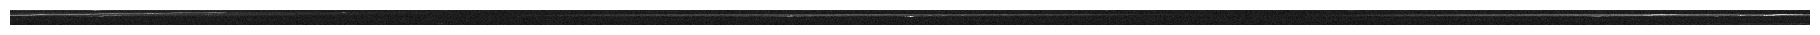

Waterfall shape: (279, 33141)


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from blimpy import Waterfall

# # ─── knobs ────────────────────────────────────────────────────────────────
# N_COL_BUFFER  = 16384                # ±N fine-chan columns as padding
# # MAX_X_BINS    = 256              # hard cap for x axis (frequency bins)
# FREQ_WINDOWS  = [(1545, 1546), (1610, 1630)]
# # PERCENTILES   = (5, 95)          # dB contrast stretch for quick-look
# DAT_COLS = [
#     "Top_Hit_#", "Drift_Rate", "SNR", "Uncorrected_Frequency",
#     "Corrected_Frequency", "Index", "freq_start", "freq_end",
#     "SEFD", "SEFD_freq", "Coarse_Channel_Number", "Full_number_of_hits"
# ]
# # ──────────────────────────────────────────────────────────────────────────

# def window_overlaps_keepband(f0, f1):
#     return any(f1 > lo and f0 < hi for lo, hi in FREQ_WINDOWS)

# # ─── 1) locate first hit whose window overlaps our bands ──────────────────
# for _, row in df.iterrows():
#     h5  = row[".h5 path"]
#     dat = row[".dat path"]

#     try:
#         hits = pd.read_table(
#             dat, sep=r"\s+", skiprows=9, names=DAT_COLS,
#             usecols=["Index", "freq_start", "freq_end", "Drift_Rate"]
#         )
#     except Exception:
#         continue

#     hits["freq_end_filled"] = np.where(
#         hits["freq_end"] != hits["freq_start"],
#         hits["freq_end"],
#         hits["freq_start"] + hits["Drift_Rate"] * 1e-6 * 300
#     )

#     hits = hits[hits.apply(
#         lambda r: window_overlaps_keepband(r["freq_start"], r["freq_end_filled"]),
#         axis=1)
#     ]
#     if not hits.empty:
#         hit = hits.iloc[0]
#         f_start_hit, f_end_hit = hit["freq_start"], hit["freq_end_filled"]
#         break
# else:
#     raise RuntimeError("No hits in requested bands")

# # ─── 2) build buffer in MHz from column count ─────────────────────────────
# hdr = Waterfall(h5, load_data=False)     # cheap header read
# foff_MHz = abs(hdr.header["foff"])       # channel width
# buffer_MHz = N_COL_BUFFER * foff_MHz

# f_lo = f_start_hit - buffer_MHz
# f_hi = f_end_hit   + buffer_MHz

# wf = Waterfall(h5, f_start=f_lo, f_stop=f_hi)

# # ─── 3) 10·log10 + optional x-axis thinning to ≤ MAX_X_BINS ───────────────
# # ─── 3) 10·log10  +  optional time-axis thinning to 279 rows ───────────────
# db = 10 * np.log10(wf.data.squeeze() + 1e-12)

# # -------- cap frequency bins (x-axis) at MAX_X_BINS -----------------------
# # n_time, n_freq = db.shape
# # if n_freq > MAX_X_BINS:
# #     x_step = int(np.ceil(n_freq / MAX_X_BINS))
# #     db     = db[:, ::x_step]  

# # -------- cap time bins (y-axis) at 279 rows ------------------------------
# TARGET_TIME = 279
# from scipy.interpolate import interp1d

# n_time, _ = db.shape
# if n_time < TARGET_TIME:
#     reps = int(np.ceil(TARGET_TIME / n_time))     # how many copies per row
#     db   = np.repeat(db, reps, axis=0)[:TARGET_TIME, :]
# elif n_time > TARGET_TIME:
#     y_step = int(np.ceil(n_time / TARGET_TIME))
#     db = db[::y_step, :]      # keep every y_step-th row
# # --------------------------------------------------------------------------

# # ─── 4) draw axes-free waterfall ──────────────────────────────────────────
# fig, ax = plt.subplots(figsize=(18, 6), dpi=100)
# ax.imshow(db, cmap="gray", origin="lower", interpolation="none")
# ax.axis("off")
# plt.subplots_adjust(0, 0, 1, 1)
# plt.show()
# print(f"Waterfall shape: {db.shape}")


Row 12: idx=237024, window=[1620.921427, 1620.918164] MHz, drift=+2.76
blimpy.io.base_reader WARNING  Given f_stop < f_start, assuming reversed values.


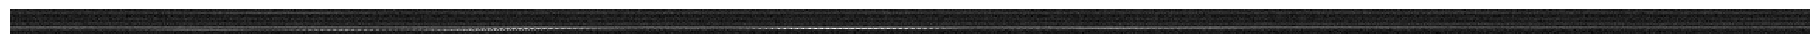

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from blimpy import Waterfall

# # ─── knobs ────────────────────────────────────────────────────────────────
# N_COL_BUFFER   = 4                       # ± this many fine-chan columns
# FREQ_WINDOWS   = [(1545, 1546), (1610, 1621)]
# DAT_COLS = [
#     "Top_Hit_#", "Drift_Rate", "SNR", "Uncorrected_Frequency",
#     "Corrected_Frequency", "Index", "freq_start", "freq_end",
#     "SEFD", "SEFD_freq", "Coarse_Channel_Number", "Full_number_of_hits"
# ]
# # ──────────────────────────────────────────────────────────────────────────

# def window_overlaps_keepband(f_start, f_end):
#     return any(f_end > lo and f_start < hi for lo, hi in FREQ_WINDOWS)

# # ─── 1) find the first hit whose window overlaps a keep-band ──────────────
# for row_idx, row in df.iterrows():
#     h5  = row[".h5 path"]
#     dat = row[".dat path"]

#     try:
#         hits = pd.read_table(
#             dat, sep=r"\s+", skiprows=9, names=DAT_COLS,
#             usecols=["Index", "freq_start", "freq_end", "Drift_Rate"]
#         )
#     except Exception as e:
#         print(f"Skipping {dat}: {e}")
#         continue

#     hits["freq_end_filled"] = np.where(
#         hits["freq_end"] != hits["freq_start"],
#         hits["freq_end"],
#         hits["freq_start"] + hits["Drift_Rate"] * 1e-6 * 300
#     )

#     hits = hits[hits.apply(
#         lambda r: window_overlaps_keepband(r["freq_start"], r["freq_end_filled"]),
#         axis=1)
#     ]

#     if not hits.empty:
#         hit = hits.iloc[0]
#         f_start_hit, f_end_hit = hit["freq_start"], hit["freq_end_filled"]
#         drift, idx = hit["Drift_Rate"], int(hit["Index"])
#         print(f"Row {row_idx}: idx={idx}, "
#               f"window=[{f_start_hit:.6f}, {f_end_hit:.6f}] MHz, "
#               f"drift={drift:.2f}")
#         break
# else:
#     raise RuntimeError("No hits overlapping the requested bands.")

# # ─── 2) derive MHz buffer from column count & open slice ──────────────────
# hdr_only = Waterfall(h5, load_data=False)          # header only, cheap
# foff_MHz = abs(hdr_only.header["foff"])            # channel width (MHz)

# buffer_MHz = N_COL_BUFFER * foff_MHz
# f_lo = f_start_hit - buffer_MHz
# f_hi = f_end_hit   + buffer_MHz

# wf = Waterfall(h5, f_start=f_lo, f_stop=f_hi, max_load=32)

# # ─── 3) dB + contrast stretch + plot ───────────────────────────────────────
# db = 10 * np.log10(wf.data.squeeze() + 1e-12)
# fig, ax = plt.subplots(figsize=(18, 6), dpi=100)
# ax.imshow(db, cmap="gray", origin="lower",
#           interpolation="none")
# ax.axis("off")
# plt.subplots_adjust(0, 0, 1, 1)
# plt.show()



In [ ]:
# fig.savefig(
#     "high_res_hits.png",
#     dpi=100,              # matches the figure’s dpi
#     bbox_inches="tight",  # crops any remaining whitespace
#     pad_inches=0
# )

In [ ]:
# %pip install imageio
# import numpy as np
# import pandas as pd
# from blimpy import Waterfall
# from multiprocessing import Pool, cpu_count
# from pathlib import Path
# from tqdm import tqdm
# # ─── replace the failing import ───────────────────────────────────────────
# try:
#     import imageio.v2 as iio          # ≥ 2.19
# except ImportError:
#     import imageio as iio             # older 2.x fallback
# # ───────────────────────────────────────────────────────────────────────────


# # ─── user knobs ────────────────────────────────────────────────────────────
# OUT_DIR      = Path("/home/jliang/gbt-rfi/highres_hits")
# SPAN_MHZ     = 20.0
# N_CORES      = max(1, cpu_count() - 1)
# FREQ_WINDOWS = [(1545, 1546), (1610, 1621)]
# CHUNKSIZE    = 8
# # ───────────────────────────────────────────────────────────────────────────

# DAT_COLS = [
#     "Top_Hit_#", "Drift_Rate", "SNR", "Uncorrected_Frequency",
#     "Corrected_Frequency", "Index", "freq_start", "freq_end",
#     "SEFD", "SEFD_freq", "Coarse_Channel_Number", "Full_number_of_hits"
# ]

# OUT_DIR.mkdir(exist_ok=True)


# def in_passband(f):
#     return any(lo <= f < hi for lo, hi in FREQ_WINDOWS)


# def to_png(data_db: np.ndarray, out_path: Path) -> None:
#     """Write 2-D dB data to an 8-bit greyscale PNG, no interpolation."""
#     # clip extreme tails for contrast
#     lo, hi = np.percentile(data_db, [5, 95])
#     data_db = np.clip(data_db, lo, hi)

#     rng = data_db.ptp()
#     if rng == 0:                       # flat patch (rare but possible)
#         img_u8 = np.zeros_like(data_db, dtype=np.uint8)
#     else:
#         img_u8 = ((data_db - data_db.min()) / rng * 255).astype(np.uint8)

#     # ImageIO happily takes a Path object even on very old versions
#     iio.imwrite(out_path, img_u8, format="png")   # threadsafe


# def process_observation(row):
#     h5  = row[".h5 path"]
#     dat = row[".dat path"]

#     try:
#         hits = pd.read_table(
#             dat, sep=r"\s+", names=DAT_COLS, skiprows=9,
#             usecols=["Index", "Corrected_Frequency"],
#         )
#     except Exception as e:
#         print(f"✘  Could not read {dat}: {e}")
#         return 0

#     hits = hits[hits["Corrected_Frequency"].apply(in_passband)]
#     saved = 0

#     for _, hit in hits.iterrows():
#         freq = hit["Corrected_Frequency"]
#         idx  = int(hit["Index"])
#         out  = OUT_DIR / f"hit_idx{idx}_{freq:.3f}MHz.png"
#         if out.exists():
#             continue

#         try:
#             f_lo, f_hi = freq - SPAN_MHZ / 2, freq + SPAN_MHZ / 2
#             wf = Waterfall(h5, f_start=f_lo, f_stop=f_hi, max_load=32)

#             data = wf.data.squeeze().astype(np.float32)
#             data_db = 10 * np.log10(data + 1e-12)   # avoid log(0)

#             to_png(data_db, out)                    # ← write the file
#             saved += 1

#         except Exception as e:
#             print(f"✘  {h5}  idx={idx}  {e}")

#     return saved


# if __name__ == "__main__":
#     if "df" not in globals():
#         raise RuntimeError("Define a DataFrame named `df` before running.")

#     rows = [row for _, row in df.iterrows()]
#     total_pngs = 0
#     with Pool(N_CORES) as pool:
#         for n in tqdm(pool.imap_unordered(process_observation, rows,
#                                           chunksize=CHUNKSIZE),
#                       total=len(rows), unit="obs", desc="Observations"):
#             total_pngs += n

#     print(f"Done – wrote {total_pngs} PNGs to {OUT_DIR}")



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Observations:  13%|█▎        | 480/3756 [00:20<02:17, 23.90obs/s]  Process ForkPoolWorker-175:



KeyboardInterrupt: 

In [ ]:
# import pandas as pd
# import blimpy as bl
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from tqdm import tqdm

# def scan_file_for_band(
#     h5_path: str,
#     band: str,
#     fmin: float,
#     fmax: float,
#     default_nfpc: int = 2**20
# ):
#     """
#     Open one .h5, read header, return list
#     whose freq range lies in [fmin, fmax].
#     """
#     records = []
#     fb = bl.Waterfall(h5_path, load_data=False)
#     hdr = fb.header

#     # skip if not the right band
#     # you could also pass row['Band'] in here if you like
#     # if row['Band'] != band: return []

#     fch1   = hdr['fch1']
#     foff   = hdr['foff']
#     nchans = hdr.get('nchans')
#     nfpc   = hdr.get('nfpc', default_nfpc)
#     n_coarse = nchans // nfpc

#     for ch in range(n_coarse):
#         f0 = ch * nfpc
#         f1 = (ch+1) * nfpc
#         f_start = fch1 + f0 * foff
#         f_stop  = fch1 + (f1-1) * foff
#         if (f_start <= fmax) and (f_stop >= fmin):
#             if f_start >= 1545 and f_stop < 1546:
#                 records.append({
#                     '.h5 path': h5_path,
#                     'Band':       band,
#                     'f_start':    f_start,
#                     'f_stop':     f_stop
#                 })
#                 break
#             elif f_start >= 1610 and f_start <= 1620:
#                 records.append({
#                     '.h5 path': h5_path,
#                     'Band':       band,
#                     'f_start':    f_start,
#                     'f_stop':     f_stop
#                 })
#                 break

#     return records

# def parallel_filter_df(
#     df: pd.DataFrame,
#     band: str = "L",
#     fmin: float = 1500,
#     fmax: float = 1650,
#     max_workers: int = 8
# ) -> pd.DataFrame:
#     # restrict to Band==L first to cut the task list down
#     df_band = df[df['Band'] == band]
#     paths   = df_band[".h5 path"].unique().tolist()

#     all_records = []
#     with ProcessPoolExecutor(max_workers=max_workers) as exe:
#         futures = {
#             exe.submit(scan_file_for_band, p, band, fmin, fmax): p
#             for p in paths
#         }
#         for fut in tqdm(as_completed(futures), total=len(futures), ascii=True,
#                         desc=f"Scanning {band}-band files"):
#             try:
#                 recs = fut.result()
#                 all_records.extend(recs)
#             except Exception as e:
#                 h5 = futures[fut]
#                 print(f"Error on {h5}: {e!r}")

#     return pd.DataFrame.from_records(all_records)

In [ ]:
# # Usage:
# filtered = parallel_filter_df(df, band="L", fmin=1500, fmax=1650, max_workers=2)
# filtered

Scanning L-band files: 100%|##########| 3756/3756 [01:10<00:00, 53.58it/s] 


,.h5 path,Band,f_start,f_stop
0,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026
1,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026
2,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026
3,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026
4,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026
...,...,...,...,...
505,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659
506,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659
507,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659
508,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659


In [ ]:
# # # 1) sample, keeping the original index labels
# # df_old = df.sample(n=1000, random_state=42)
# # # 2) drop those exact rows from df
# # df = df.drop(index=df_old.index).reset_index(drop=True)
# # # 4) finally, sample 1,000 more from the remainder
# df = (
#     filtered
#     .merge(
#         df[['.h5 path', '.dat path']].drop_duplicates(),
#         on='.h5 path',
#         how='left'
#     )
# )
# df

,.h5 path,Band,f_start,f_stop,.dat path
0,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026,/home/obs/turboseti/AGBT19B_999_121/blc73_blp0...
1,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026,/home/obs/turboseti/AGBT19B_999_121/blc73_blp0...
2,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026,/home/obs/turboseti/AGBT19B_999_121/blc73_blp0...
3,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026,/home/obs/turboseti/AGBT19B_999_121/blc73_blp0...
4,/datag/pipeline/AGBT19B_999_121/blc73_blp03/bl...,L,1619.999884,1619.997026,/home/obs/turboseti/AGBT19B_999_121/blc73_blp0...
...,...,...,...,...,...
505,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659,/home/obs/turboseti/AGBT22B_999_25/blc13_blp03...
506,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659,/home/obs/turboseti/AGBT22B_999_25/blc13_blp03...
507,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659,/home/obs/turboseti/AGBT22B_999_25/blc13_blp03...
508,/datag/pipeline/AGBT22B_999_25/blc13_blp03/blc...,L,1618.652344,1615.722659,/home/obs/turboseti/AGBT22B_999_25/blc13_blp03...


In [ ]:
# import cv2

# img = cv2.imread("/datax/scratch/jliang/dataset/images/train/img_31693.jpg")
# height, width, channels = img.shape

# print(f"Width: {width}, Height: {height}, Channels: {channels}")


Width: 781, Height: 524, Channels: 3


In [10]:
# fb_mid.info() # shape: (279; 1; 65,536)

In [11]:
# fb_high.info() # shape: (16; 1; 67,108,864)

In [ ]:
# def overlaps_existing(x_center, width, used_intervals):
#     x_min = x_center - width / 2
#     x_max = x_center + width / 2
#     for (xmin_used, xmax_used) in used_intervals:
#         if not (x_max <= xmin_used or x_min >= xmax_used):  # overlap detected
#             return True
#     return False

In [ ]:
# small_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

In [ ]:
# import blimpy as bl

# def build_tasks(df):
#     """
#     Return a list of h5_path strings, excluding any file
#     where at least one coarse channel falls into a notch filter.
#     """
#     GBT_NOTCH_FILTERS = {
#         "L": [(1200, 1340)],
#         "S": [(2300, 2360)],
#     }

#     tasks = []

#     for _, row in df.iterrows():
#         h5   = row[".h5 path"]
#         band = row["Band"]              # e.g., 'L', 'S', etc.
#         fb   = bl.Waterfall(h5, load_data=False)

#         nfreq = fb.header.get("nchans")
#         nfpc  = fb.header.get("nfpc", 1024)
#         fch1  = fb.header["fch1"]
#         foff  = fb.header["foff"]
#         n_coarse = nfreq // nfpc

#         # Check every coarse channel; if any overlap, skip the file
#         should_skip = False
#         if band in GBT_NOTCH_FILTERS:
#             for ch in range(n_coarse):
#                 f0, f1 = sorted([
#                     fch1 + ch     * nfpc * foff,
#                     fch1 + (ch+1) * nfpc * foff
#                 ])
#                 for lo, hi in GBT_NOTCH_FILTERS[band]:
#                     if (lo <= f0 <= hi) or (lo <= f1 <= hi):
#                         should_skip = True
#                         break
#                 if should_skip:
#                     break

#         if not should_skip:
#             tasks.append(h5)

#     return tasks


# def split_tasks(tasks, train_frac=0.8, seed=42):
#     """
#     Shuffle & split the flat task list into train vs. val sets.
#     Returns two sets of (h5_path, channel_idx).
#     """
#     random.seed(seed)
#     shuffled = tasks.copy()
#     random.shuffle(shuffled)
#     cut = int(train_frac * len(shuffled))
#     train = set(shuffled[:cut])
#     val   = set(shuffled[cut:])
#     return train, val

In [ ]:
# import pandas as pd
# from pathlib import Path
# import numpy as np
# from PIL import Image, ImageDraw
# import blimpy as bl
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from tqdm import tqdm
# import gc

# DAT_COLS = [
#     'Top_Hit_#', 'Drift_Rate', 'SNR', 'Uncorrected_Frequency',
#     'Corrected_Frequency', 'Index', 'freq_start', 'freq_end',
#     'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 'Full_number_of_hits'
# ]
# OUTPUT_DIR = Path("/home/jliang/gbt-rfi/highres_hits")
# PAD_WIDTH   = 4    # for filename padding (if desired)
# NUM_WORKERS = 2

# # build_tasks should now just return a list of h5_path strings (no channel)
# file_tasks = build_tasks(df)  # e.g. ["/.../file1.h5", "/.../file2.h5", ...]

# # map each h5 to its .dat file
# dat_map = {row[".h5 path"]: row[".dat path"] for _, row in df.iterrows()}

# def save_scan(h5_path, dat_path, out_base, pad_width, train_set, val_set):
#     # Load the full waterfall
#     fb = bl.Waterfall(h5_path, load_data=True)
#     # after fb = bl.Waterfall(...)
#     data = fb.data.squeeze()                   # Y×X in (float32 or float64)
#     # allocate the final uint8 array
#     img8 = np.empty_like(data, dtype=np.uint8)

#     # 2) Normalize + log10 → one uint8 array
#     d_min, d_max = data.min(), data.max()
#     scale = 255.0 / (d_max - d_min + 1e-6)
#     img8 = np.empty_like(data, dtype=np.uint8)
#     for t in range(data.shape[0]):
#         row = 10 * np.log10(data[t])
#         img8[t] = np.clip((row - d_min) * scale, 0, 255).astype(np.uint8)

#     # free the big float array
#     del data
#     gc.collect()
#     # now `img8` exists but no `wf` or `norm` lingers
#     hdr = fb.header

#     # choose subset
#     subset = 'train' if h5_path in train_set else 'val'
#     base   = Path(h5_path).stem
#     img_dir    = out_base / subset / 'images'
#     labels_dir = out_base / subset / 'labels'
#     vis_dir    = out_base / subset / 'visualization'
#     for d in (img_dir, labels_dir, vis_dir):
#         d.mkdir(parents=True, exist_ok=True)

#     # Read all hits for this scan
#     hits = pd.read_table(dat_path, sep='\s+', names=DAT_COLS, skiprows=9)
#     if hits.empty:
#         return

#     # full frequency slice
#     block = img8  # shape (time, freq)
#     h_img, w_img = block.shape


#     # compute first & last channel frequencies
#     f_start = hdr['fch1']
#     f_stop  = hdr['fch1'] + (hdr.get('nchans') - 1) * hdr['foff']

#     fname = f"scan_f_{f_start:.4f}_{f_stop:.4f}.png"

#     # 1) Save the spectrogram image
#     Image.fromarray(img8).save(img_dir / fname)

#     # # 2) Write YOLO labels for each hit
#     # txt_path = labels_dir / fname.replace('.png', '.txt')
#     # with open(txt_path, 'w') as lf:
#     #     for _, hit in hits.iterrows():
#     #         x_min = hit['freq_start']
#     #         x_max = hit['freq_end']
#     #         if x_max - x_min == 0:
#     #             x_max = x_min + row['Drift_Rate'] * 1e-6 * 300  # Adjust width if zero
#     #         y_min = 0
#     #         y_max = h_img

#     #         x_center = (x_min + x_max) / 2 / w_img
#     #         y_center = (y_min + y_max) / 2 / h_img
#     #         pixel = 1 / w_img
#     #         width = max((x_max - x_min) / w_img, pixel)
#     #         height = (y_max - y_min) / h_img

#     #         lf.write(f"0 {x_center:.8f} {y_center:.8f} {width:.8f} {height:.8f}\n")

#     # # 3) Draw visualization
#     # vis  = Image.fromarray(img8).convert('RGB')
#     # draw = ImageDraw.Draw(vis)
#     # for _, hit in hits.iterrows():
#     #     x1 = int((hit['freq_start'] - f_start) / hdr['foff'])
#     #     x2 = int((hit['freq_end']   - f_start) / hdr['foff'])
#     #     x1, x2 = max(0, x1), min(w_img-1, x2)
#     #     draw.rectangle([x1, 0, x2, h_img-1], outline='red', width=2)
#     # vis.save(vis_dir / fname)
#     # del img8
#     gc.collect() 

# if __name__ == "__main__":
#         # split_tasks should accept a list of h5_paths and return (train_set, val_set)
#     train_set, val_set = split_tasks(file_tasks)

#     with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
#         futures = {
#             executor.submit(
#                 save_scan,
#                 h5_path, dat_map[h5_path],
#                 OUTPUT_DIR, PAD_WIDTH,
#                 train_set, val_set
#             ): h5_path
#             for h5_path in file_tasks
#             if h5_path in dat_map
#         }

#         for future in tqdm(as_completed(futures), total=len(futures), ascii=True, desc="Processing scans"):
#             h5_path = futures[future]
#             try:
#                 future.result()
#             except Exception as e:
#                 print(f"Error processing {h5_path}: {e}")



In [ ]:
# from pathlib import Path
# import scipy.ndimage as ndi
# from scipy.stats import kurtosis
# import imageio
# from PIL import Image, ImageDraw
# import gc
# import traceback
# def process_file(job):
#     (h5_path, channels, gidxs,
#      base_dir, class_id, train_set, val_set,
#      pad_width) = job

#     # Load .h5 once
#     fb   = bl.Waterfall(h5_path, load_data=True)
#     data = 10*np.log10(fb.data.squeeze())  # (ntime, nfreq)

#     for ch_idx, gidx in zip(channels, gidxs):
#         subset = "train" if (h5_path,ch_idx) in train_set else "val"
#         img_dir = Path(base_dir)/subset/"images"
#         lbl_dir = Path(base_dir)/subset/"labels"
#         vis_dir = Path(base_dir)/"visualization"/subset
#         for d in (img_dir,lbl_dir,vis_dir): d.mkdir(parents=True, exist_ok=True)

#         # Extract & clean the block
#         cw = fb.header.get("nfpc",1024)
#         f0, f1 = ch_idx*cw, (ch_idx+1)*cw
#         block = data[:,f0:f1]
#         low, high = int(0.15*cw), int(0.85*cw)
#         block = block[:,low:high]
#         h_img, w_img = block.shape

#         # Remove vertical line artifact (DC spike) in the central few columns
#         rows, cols = block.shape

#         # 1) Define a little window around the true center column
#         mid = cols // 2
#         half_win = 2                 # look 2 columns on either side
#         start = max(mid - half_win, 0)
#         end   = min(mid + half_win + 1, cols)

#         # 2) Compute the mean of each of those columns
#         center_window = block[:, start:end]            # shape = (rows, window_width)
#         vert_means    = center_window.mean(axis=0)     # length = window_width

#         # 3) Locate the spike RELATIVE to the window, then map back
#         rel_idx    = np.argmax(vert_means)             # in [0 .. window_width-1]
#         center_col = start + rel_idx                   # actual column index in block

#         # 4) Replace that column by the average of its two neighbors (if they exist)
#         left_col  = center_col - 1
#         right_col = center_col + 1

#         if 0 <= left_col < cols and 0 <= right_col < cols:
#             block[:, center_col] = 0.5*(block[:, left_col] + block[:, right_col])
#         elif 0 <= left_col < cols:
#             block[:, center_col] = block[:, left_col]
#         elif 0 <= right_col < cols:
#             block[:, center_col] = block[:, right_col]


#         # after artifact fix
#         del rows, cols, vert_means, center, left_col, right_col


#         # Build img for SF
#         norm = (block - block.min())/(np.ptp(block)+1e-6)
#         img3 = np.stack([norm]*3, axis=-1).astype(np.float32)
#         gray8 = (255*norm).astype(np.uint8)

#         lbl, num = ndi.label(binary)
#         sizes = np.bincount(lbl.ravel())
#         clean = np.zeros_like(binary)
#         for i, sz in enumerate(sizes):
#             if i>0 and sz>=50:      # just drop very tiny blobs
#                 clean[lbl==i] = True


#         # # YOLO boxes
#         # boxes = generate_yolo_boxes(filled)
#         # if boxes is None:
#         #     boxes = []
#         # # Merge overlapping boxes
#         # boxes = merge_overlaps_by_coords(boxes)
#         del sf_map, ued_map, canny_map, hough_map
#         del fused_global, zmap
#         gc.collect()
#         # [.. save PNG, write .txt, draw visualization exactly as before ..]
#         # Calculate frequency range of this coarse channel
#         f_start = fb.header['fch1'] + f0 * fb.header['foff']
#         f_stop  = fb.header['fch1'] + (f1 - 1) * fb.header['foff']
        
#         # Build filename
#         f_start = fb.header['fch1'] + f0 * fb.header['foff']
#         f_stop  = fb.header['fch1'] + (f1 - 1) * fb.header['foff']
#         kurt_val = kurtosis(gray8.flatten(), fisher=False)
#         fn = f"img_{kurt_val:0{pad_width}.2f}_f_{f_start:.4f}_{f_stop:.4f}.png"
#         img_path = img_dir / fn
#         txt_path = lbl_dir / fn.replace(".png", ".txt")

#         # Save image
#         arr8 = (255 * (block - block.min()) / (np.ptp(block) + 1e-6)).astype(np.uint8)
#         img = Image.fromarray(np.stack([arr8]*3, axis=-1))
#         img.save(img_path)

#         # Write YOLO labels
#         with open(txt_path, "w") as f:
#             for x_c, y_c, w_n, h_n in boxes:
#                 f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}\n")


#         # Draw & save visualization
#         vis_img = img.convert("RGB")
#         draw    = ImageDraw.Draw(vis_img)
#         for x_c, y_c, w_n, h_n in boxes:
#             xc, yc = x_c*w_img, y_c*h_img
#             bw, bh = w_n*w_img, h_n*h_img
#             x0, y0 = int(xc - bw/2), int(yc - bh/2)
#             x1, y1 = int(xc + bw/2), int(yc + bh/2)
#             draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
#         vis_img.save(vis_dir/fn)
#         debug_dir = vis_dir/"debug_masks"
#         debug_dir.mkdir(exist_ok=True)
#         imageio.imwrite(debug_dir/f"binary_{kurt_val}_{f_start}_{f_stop}.png",   (binary*255).astype(np.uint8))
#         del binary, vis_img, draw
#     del data, fb, h5_path, channels, gidxs
#     gc.collect()

# if __name__ == "__main__":
#     tasks = build_tasks(df)
#     train_set, val_set = split_tasks(tasks)

#     # 2) build job tuples of exactly what process_file unpacks:
#     job_args = []
#     BASE_DIR = "/datax/scratch/jliang/dataset_moe_gate-nosegment"
#     NUM_WORKERS = 2
#     class_id = 0  # Assuming a single class for simplicity
#     pad_width = 4  # Zero-padding width for gidx in filenames
#     for idx, (h5_path, ch_idx) in enumerate(tasks):
#         job = (
#             h5_path,
#             [ch_idx],        # channels
#             [idx],           # gidxs
#             BASE_DIR,
#             class_id,
#             train_set,
#             val_set,
#             pad_width
#         )
#         job_args.append(job)

#     # 3) submit each job as a single argument
#     with ProcessPoolExecutor(max_workers=NUM_WORKERS) as exe:
#         futures = {
#             exe.submit(process_file, job): (job[0], job[1])
#             for job in job_args
#         }

#         for future in tqdm(as_completed(futures), total=len(futures)):
#             h5, ch_list = futures[future]
#             try:
#                 future.result()
#             except Exception as e:
#                 print(f"Error processing {h5} channel {ch_list}: {e}")
#                 traceback.print_exc()
#                 raise



In [ ]:
# # Shuffle and split
# total_indices = list(range(len(df)))
# random.seed(42)
# random.shuffle(total_indices)

# split_idx = int(0.8 * len(total_indices))
# train_indices = set(total_indices[:split_idx])
# val_indices = set(total_indices[split_idx:])

# # Create all needed dirs
# base_dir = '/datax/scratch/jliang/small_dataset2'
# image_train_dir = os.path.join(base_dir, 'train/images')
# label_train_dir = os.path.join(base_dir, 'train/labels')
# image_val_dir = os.path.join(base_dir, 'val/images')
# label_val_dir = os.path.join(base_dir, 'val/labels')

# drifts = []
# widths = []
# for d in [image_train_dir, label_train_dir, image_val_dir, label_val_dir]:
#     os.makedirs(d, exist_ok=True)

# for index in range(len(df) - 1, len(df)):
#     # Wait for memory if needed
#     threshold = 20 * (1024 ** 3)  # 20 GB
#     while psutil.virtual_memory().available < threshold:
#         print('Waiting for memory to free up…')
#         time.sleep(180)
    
#     dat = df['.dat path'].iloc[index]
#     dat_df = pd.read_table(dat, sep='\s+', names=[
#             'Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency',
#             'Corrected_Frequency','Index','freq_start','freq_end',
#             'SEFD','SEFD_freq','Coarse_Channel_Number','Full_number_of_hits'
#             ], skiprows=9)
    
#     if len(dat_df) != 0:
#         file_path = df['.h5 path'].iloc[index]
#         #print(f'Processing file {index}: {file_path}')
#         fb = bl.Waterfall(file_path)
#         data = fb.data  # shape: (279, 1, 65536)

#         # Choose correct folder based on split
#         if index in train_indices:
#             image_dir = image_train_dir
#             label_dir = label_train_dir
#         else:
#             image_dir = image_val_dir
#             label_dir = label_val_dir
#         # Save image
#         # img_name = f'img_{index:05d}.jpg' # change later to 5d
#         # out_path = os.path.join(image_dir, img_name)
#         # fig, ax = plt.subplots(figsize=(6.4, 6.4), dpi=100)
#         # ax.imshow(10 * np.log10(data).squeeze(), aspect='auto', cmap='viridis')
#         # ax.axis('off')                         # removes ticks and axis lines
#         # plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # no margins
#         # plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
#         # plt.close(fig)

#         # Save labels
#         label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))
#         with open(label_path, 'w') as f:

#             img_height, img_width = data.squeeze().shape

#             # hits
#             for _, row in dat_df.iterrows():
#                 x_min = row['freq_start']
#                 x_max = row['freq_end']
#                 if x_max - x_min == 0:
#                     x_max = x_min + row['Drift_Rate'] * 1e-6 * 300  # Adjust width if zero
#                 y_min = 0
#                 y_max = img_height

#                 x_center = (x_min + x_max) / 2 / img_width
#                 y_center = (y_min + y_max) / 2 / img_height
#                 pixel = 1 / img_width
#                 width = max((x_max - x_min) / img_width, pixel)
#                 height = (y_max - y_min) / img_height

#                 drifts.append(row['Drift_Rate'])
#                 widths.append(width)

#                 f.write(f"0 {x_center:.8f} {y_center:.8f} {width:.8f} {height:.8f}\n")

Processing file 29345: /datag/pipeline/AGBT22B_999_25/blc16_blp06/blc16_guppi_59902_24005_HIP50744_0057.rawspec.0002.h5


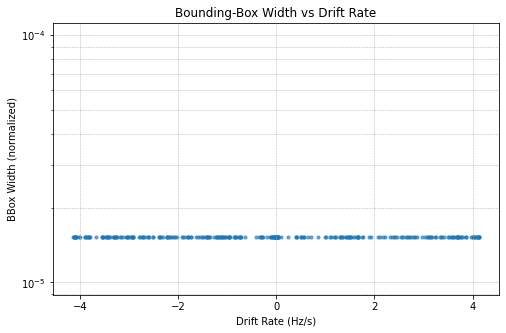

In [ ]:
# plt.figure(figsize=(8,5))
# plt.scatter(drifts, widths, s=10, alpha=0.6)
# plt.xlabel('Drift Rate (Hz/s)')
# plt.ylabel('BBox Width (normalized)')
# plt.title('Bounding-Box Width vs Drift Rate')
# plt.yscale('log')       # optional: log-scale if widths span many orders
# plt.grid(True, which='both', ls='--', lw=0.5)
# out_plot = 'bbox_width_vs_drift.png'
# plt.savefig(out_plot, dpi=150, bbox_inches='tight')
# plt.show()
